In [1]:
import csv
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

# Predicting Hotel Clicks

## Data Caveats

- The order of clicks given in the 'activity' log is meaningless
- We do not know which hotels a user has seen but not clicked on, only those which the user clicked on
- It is possible, but according to the data extremely unlikely, for a user to click on a hotel twice

## Using user / hotel features

### Naive approach

Take as independent variables: user gender, user continent, and hotel rating to predict whether or not a user will click on the hotel.

#### Issues:

- Obviously this discounts a user's click history, which is not ideal.
- It's not clear that a user not clicking on a hotel means that they wouldn't click on that hotel.
    - This means that we have to generate negative examples which will be incorrect.
    - For this reason I won't be exploring this

### Predicting hotel likelihood by rating

Instead of using the hotel rating as input, we make it the dependent variable and see if we can predict what hotel they will click on next by finding the one with the rating closest to what the model thinks the user's preference is.

#### Issues:

- Still disregards click history.
    - Taking into this account might be the next step. 
    - Could, for example, use the average rating of hotels that the user has previously clicked on
        - This won't work as we can't really say which hotels a user has previously clicked on with the data given
- The idea of finding the closest hotel by rating is also deeply flawed, as most hotels have a rating of 3.5 / 4, so we won't be able to easily distinguish hotels by rating.
- Results: Models tried learn only to predict the mean (i.e. both a Decision Tree and Linear Regression give an R^2 near 0), implying that there's no real correlation in the sample to learn on

## Using Collaborative Filtering

### Naive approach

Make a user-hotel matrix, filling in whether or not a user has clicked on a hotel. For each user, find 'similar' users by which hotels they clicked on (i.e. find the other user that correlates highly with this user), and see which hotel they are most likely to click on next

#### Issues: 

- Same issue as in naive approach where we don't know if a user has viewed the hotel but decided not to click on it
    - Workaround: treat all non-clicks as unknowns instead of refusal to click
- Users may click on the same hotel twice, which we wouldn't really handle very well
    - This only happens once in the data, so we can safely ignore it
- It looks like users click on about ~4 hotels on average, which means that we're going to have a very sparse matrix to fill in.
- Not taking into account hotel ratings or user information may be suboptimal
    - It would appear that this information may not be as important to the task as previously thought.

In [2]:
# Let's do some data exploration to answer a few questions

def load_tsv(fn):
    #result = defaultdict(lambda : [])
    with open(fn, 'r') as f:
        reader = csv.DictReader(f, delimiter='\t')
        result = {field:[] for field in reader.fieldnames}
        for row in reader:
            for field in row:
                result[field].append(row[field])
    return result

all_activity = load_tsv('activity.txt')
all_hotels = load_tsv('hotels.txt')
all_users = load_tsv('users.txt')

# setup reverse maps for categorical variables
all_continents = sorted(list(set(all_users['home continent'])))
all_gender = sorted(list(set(all_users['gender'])))
continents_rind = {continent:ind for ind, continent in enumerate(all_continents)}
gender_rind = {gender:ind for ind, gender in enumerate(all_gender)}

In [3]:
# let's see how many users (if any) clicked on a hotel twice
# we'll use all_activity for this:
user_hotel_map = defaultdict(lambda : [])
hotel_user_map = defaultdict(lambda : [])
for user, hotel in zip(all_activity['user'], all_activity['hotel']):
    user_hotel_map[user].append(hotel)
    hotel_user_map[hotel].append(user)
avg_clicks = 0
for user in user_hotel_map:
    # not the most efficient way to do this
    if len(set(user_hotel_map[user])) < len(user_hotel_map[user]):
        print(user_hotel_map[user])
        print(user)
    avg_clicks += len(user_hotel_map[user])
avg_clicks /= len(user_hotel_map)
print(avg_clicks)

# So it looks like there's only one user that clicked on a hotel twice, which is weird
# Generally though this means we can't assume that a user won't click on a hotel twice in our final predictions
# What's the average amount of activity that we can expect from a user?

['2', '2']
4232
3.79181338028169


2
65
3.19754029923
2.0


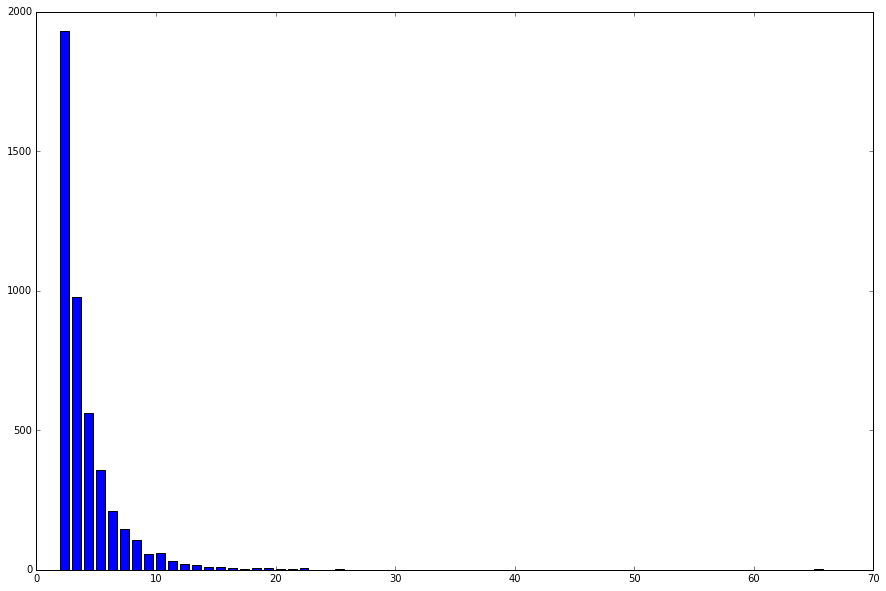

In [50]:
# It would also appear that we have at least 2 clicks for every user
print(min([len(user_hotel_map[user]) for user in user_hotel_map]))
print(max([len(user_hotel_map[user]) for user in user_hotel_map]))
print(np.std([len(user_hotel_map[user]) for user in user_hotel_map]))
nclicks_histogram = np.histogram([len(user_hotel_map[user]) for user in user_hotel_map], range=(0,67), bins=67)
plt.figure(figsize=(15,10))
plt.bar(nclicks_histogram[1][:-1], nclicks_histogram[0], width=0.75)
# What does this histogram of clicks look like? It appears that primarily users click on 2 hotels.
print(nclicks_histogram[1][np.argmax(nclicks_histogram[0])])

In [5]:
# Let's build a training and validation each set consisting of a subset of users
# We'll then filter the activity with these constraints into a train activity and validation activity

# build train/valid
from sklearn.cross_validation import train_test_split
train_users, valid_users = tuple(map(set, train_test_split(all_users['user'], test_size=0.2)))

/usr/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


<Container object of 10 artists>

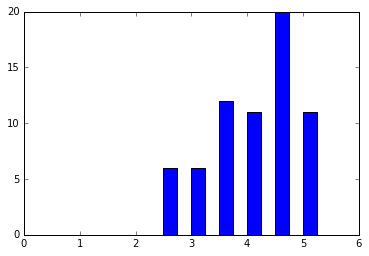

In [53]:
# Let's see a histogram of hotel ratings, to see if it is a meaningful measurement


rating_histogram, bins = np.histogram(list(map(float, all_hotels['star_rating'])),
                                     bins=10, range=(0,5))
plt.bar(bins[1:], rating_histogram, width=0.25)

In [54]:
print(np.average(list(map(float, all_hotels['star_rating']))))
print(bins[np.argmax(rating_histogram)])

3.5303030303
4.0


0.299688091532
Is it significant? True


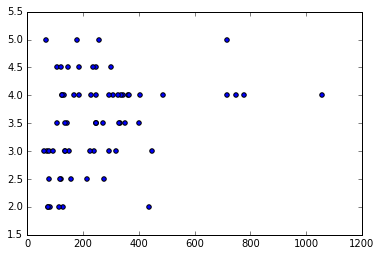

In [56]:
# Does the amount of clicks a hotel gets correlate well with its rating?
hotel_rating_map = {hotel:float(rating) for hotel, rating in zip(all_hotels['hotel'], all_hotels['star_rating'])}
ratings = []
nclicks = []
for hotel in hotel_user_map:
    ratings.append(hotel_rating_map[hotel])
    nclicks.append(len(hotel_user_map[hotel]))
print(np.corrcoef(ratings, nclicks)[0,1])
# calculate significance using simple t-test
r = np.corrcoef(ratings, nclicks)[0,1]
tval = r*np.sqrt((len(ratings)-2) / (1-r**2))
print("Is it significant? %s" % (tval > 2))
# Let's plot it as well
plt.scatter(nclicks, ratings)

In [8]:
# So it looks like there isn't a super strong correlation, which means that we can't just assume that highly
# rated hotels will get more clicks

<Container object of 10 artists>

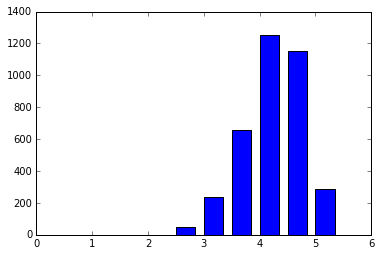

In [9]:
# Let's do the naive user feature approach, where we predict the rating of a hotel that a user is most likely
# to click on based only on their non-historical features, i.e. continent and gender

user_props_mat = {user:{'gender':gender,'cont':cont} for user, gender, cont in zip(all_users['user'],
                                                                                   all_users['gender'],
                                                                                   all_users['home continent'])}
# let's move activity to tuples of user / hotel
train_activity = []
valid_activity = []
for user, hotel in zip(all_activity['user'], all_activity['hotel']):
    if user in train_users:
        train_activity.append((user, hotel))
    else:
        valid_activity.append((user, hotel))
        
# Let's make the naive dataset
def one_hot(category, rind):
    encoded = np.zeros((1,len(rind)))
    encoded[:,rind[category]] = 1
    return encoded


def make_data_naive(user_set):
    data = []
    ratings = []
    for user in train_users:
        # make a feature matrix of users gender and continent
        feature_vec = np.hstack([one_hot(user_props_mat[user]['gender'], gender_rind),
                                 one_hot(user_props_mat[user]['cont'], continents_rind)])
        rating = np.average([hotel_rating_map[hotel] for hotel in user_hotel_map[user]])
        data.append(feature_vec)
        ratings.append(rating)
    return np.vstack(data), np.vstack(ratings)
naive_train_data = make_data_naive(train_users)
naive_valid_data = make_data_naive(valid_users)

# Let's look at the histogram of these ratings
avg_rating_hist = np.histogram(naive_train_data[1], range=(0,5), bins=10)
plt.bar(avg_rating_hist[1][1:], avg_rating_hist[0], width=0.35)
# I would hypothesize that this will fail entirely. The distribution of users by avg hotel ratings 
# that they clicked on is given below, which implies to me that most of the time the model will predict the mean

In [10]:
from sklearn.linear_model import LinearRegression
# Predict the average rating of a hotel that a user (based solely on gender and continent) will click on

rating_predictor = LinearRegression(normalize=True)
rating_predictor.fit(*naive_train_data)

/usr/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [11]:
rating_predictor.score(*naive_train_data)
rating_predictor.predict(naive_train_data[0])

array([[ 3.70898438],
       [ 3.73242188],
       [ 3.73242188],
       ..., 
       [ 3.73242188],
       [ 3.73242188],
       [ 3.73242188]])

In [12]:
print(rating_predictor.coef_)

[[  2.63482494e+12   2.63482494e+12   4.41044440e+12   4.41044440e+12
    4.41044440e+12   4.41044440e+12   4.41044440e+12   4.41044440e+12
    4.41044440e+12]]


In [13]:
# This probably isn't worth pursuing, it's clear that the model just predicts something very close to the
# mean rating. Let's try a decision tree instead anyways.
from sklearn.tree import DecisionTreeRegressor
rating_tree = DecisionTreeRegressor()
rating_tree.fit(*naive_train_data)
rating_tree.score(*naive_train_data) # No better

0.0042538317578499907

In [14]:
rating_tree.predict(naive_train_data[0])

array([ 3.70948224,  3.72635132,  3.72635132, ...,  3.72635132,
        3.72635132,  3.72635132])

In [15]:
### Naive Collaborative Filtering attempt
import random

# We'll see how far we can get with just predicting the "next" hotel click by (for each user) holding out a
# random hotel click, and using collaborative filtering to try and predict that user's next hotel click
# this doesn't take into account user features, but it would appear that these don't correlate to particular
# hotels anyways. The biggest issue with this is that we do not know if a user has 'passed over' a hotel or
# instead just hasn't seen it yet. So, ultimately, this doesn't make a lot of theoretical sense since 

# make user-hotel matrix
users_list = sorted(all_users['user'])
hotels_list = sorted(all_hotels['hotel'])
hotels_rind = {hotel:ind for ind, hotel in enumerate(hotels_list)}
users_rind = {user:ind for ind, user in enumerate(users_list)}


user_hotel_mat = np.zeros((len(user_hotel_map), len(hotel_user_map)))
left_out_map = {}
for user in user_hotel_map:
    random.shuffle(user_hotel_map[user]) # order doesn't matter anyways
    left_out_map[user] = user_hotel_map[user][-1] 
    # this going to be used only for the evaluation of collab filtering
    for hotel in user_hotel_map[user]:
        user_hotel_mat[users_rind[user], hotels_rind[hotel]] = 1


In [16]:
import time
def find_similar_user(user, user_hotel_mat, leave_out=None):
    # figure out for each user how well their clicks correlate with this user's clicks
    user_similarities = {}
    if leave_out is not None: # for evaluation purposes
        user_hotel_mat[users_rind[user], hotels_rind[leave_out]] = 0
    for other_user in users_rind:
        if other_user == user:
            continue
        user_similarities[other_user] = np.corrcoef(user_hotel_mat[users_rind[user],:],
                                                    user_hotel_mat[users_rind[other_user],:])[0,1]
    if leave_out is not None: # I'm not proud of this, but copying the matrix just to make one change is slow
        user_hotel_mat[users_rind[user], hotels_rind[leave_out]] = 1
    return user_similarities

min_max_corr = 1
for usr in []:
    tic = time.time()
    max_corr = max(find_similar_user(usr, user_hotel_mat).values())
    toc = time.time() - tic
    #print("Took %0.2f seconds" % toc) # Note: this takes ~0.2 seconds per user, total ~15min
    if max_corr < min_max_corr:
        min_max_corr = max_corr
        
print(min_max_corr)

1


In [30]:
def predict_next(user, user_hotel_mat, use_left_out=True):
    # first find a similar user
    if use_left_out:
        leave_out = left_out_map[user]
    else:
        leave_out = None
    similar_users = find_similar_user(user, user_hotel_mat, leave_out=leave_out)
    # so now we'll try to fill in the non-clicks by weighting each of the similar users by their similarity
    already_clicked_mask = [hotels_rind[hotel] for hotel in user_hotel_map[user] if (hotel != leave_out)]
    recommendations = np.sum([user_hotel_mat[users_rind[usr]]*similar_users[usr] for usr in similar_users
                              if (similar_users[usr] > 0)], 
                             axis=0)
    if not isinstance(recommendations, np.ndarray):
        return random.choice(hotels_list)
    recommendations[already_clicked_mask] = -np.inf
    return hotels_list[np.argmax(recommendations)]


    
# let's evaluate it. I'm expecting awful, terrible, I mean really bad results
correct = 0
predictions = {}
for user in user_hotel_map:
    next_click = predict_next(user, user_hotel_mat)
    predictions[user] = next_click
    #print("User %s: predicted: %s, true: %s" % (user, next_click, left_out_map[user]))
    if next_click == left_out_map[user]:
        correct += 1
print(correct / len(user_hotel_map))

0.11795774647887323


/usr/lib/python3.5/site-packages/numpy/lib/function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


<Container object of 66 artists>

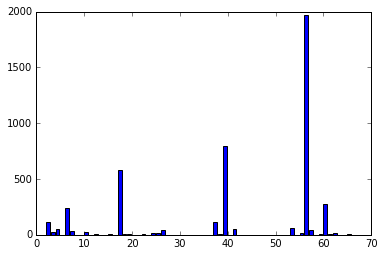

In [33]:
# let's look at a histogram of the predictions
pred_hist = np.histogram(list(map(int, predictions.values())), range=(1,67), bins=66)
plt.bar(pred_hist[1][:-1], pred_hist[0])

<Container object of 66 artists>

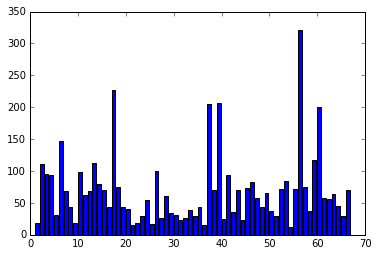

In [34]:
gt_hist = np.histogram(list(map(int, left_out_map.values())), range=(1,67), bins=66)
plt.bar(gt_hist[1][:-1], gt_hist[0])

In [47]:
# So presumably the more popular hotels were predicted more often (since they appear in the 'left-out' more often)
# We can check this real quick

top5_pred = sorted(pred_hist[1][:-1], key=lambda x: -pred_hist[0][int(x)-1])[:5]
print(top5_pred)

[56.0, 39.0, 17.0, 60.0, 6.0]


In [48]:
sorted(hotel_user_map.keys(), key=lambda x: -len(hotel_user_map[x]))[:5]

['56', '60', '17', '37', '39']

Overall this naive collaborative filtering approach does significantly better than a random prediction (which isn't saying much) but since we don't know the true ordering of the clicks it's hard to say if the 'leave out' method of evaluation is a good way to evaluate how well it will do on predicting the true 'next click'.

Additionally, a way to incorporate the star ratings would be useful. I would argue (based on the attempt at predicting average hotel rating clicked on) that the continent and gender aren't terribly predictive, but it would surprise me if the ratings of hotels that a user had _previously_ clicked on couldn't be incorporated in a useful way.